In [1]:
file_dir = '../data/combinedWav/'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy
import scipy.signal as signal
import scipy.ndimage as ndimage


def get_wav_files():
    return [f for f in os.listdir(file_dir) if f.endswith('.wav')]

def get_wav_data(file):
    return wav.read(file_dir + file)

def get_wav_data_by_name(name):
    return wav.read(file_dir + name)

def get_wav_data_by_index(index):
    return get_wav_data(get_wav_files()[index])




/tmp/ipykernel_1132715/3687763561.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  return wav.read(file_dir + file)
/tmp/ipykernel_1132715/3687763561.py:18: WavFileWarning: Incomplete chunk ID: b'\x00\x00', ignoring it.
  return wav.read(file_dir + file)


Unique sample rates: [48000, 96000, 44100]
Unique lengths: [227328, 350208, 75776, 221184, 294912, 108544, 88064, 223232, 141312, 22539, 118802, 176146, 53269, 57373, 84000, 45102, 75827, 38965, 264246, 161852, 20540, 61502, 75840, 81996, 96336, 28755, 86100, 36949, 32852, 254036, 20570, 165979, 163934, 297056, 188517, 28777, 22634, 2156, 221296, 270456, 45176, 4220, 16512, 43136, 182405, 104582, 88200, 125068, 112784, 102548, 227481, 135321, 190618, 135324, 61596, 467105, 137377, 32938, 100522, 49324, 104621, 10414, 100532, 10422, 37046, 209080, 262333, 272575, 22719, 37056, 30914, 463050, 121056, 166113, 149730, 76001, 49377, 127206, 53480, 65771, 61680, 6387, 61693, 24830, 24832, 57600, 47368, 22795, 176400, 166170, 47388, 12573, 14622, 59681, 35107, 88357, 78119, 178476, 94508, 184625, 51512, 49469, 90434, 141641, 264529, 190809, 117083, 80220, 65889, 98658, 37221, 12648, 67944, 55661, 162159, 76145, 51570, 14711, 33152, 96640, 604546, 110989, 31118, 178585, 104859, 113051, 43427, 

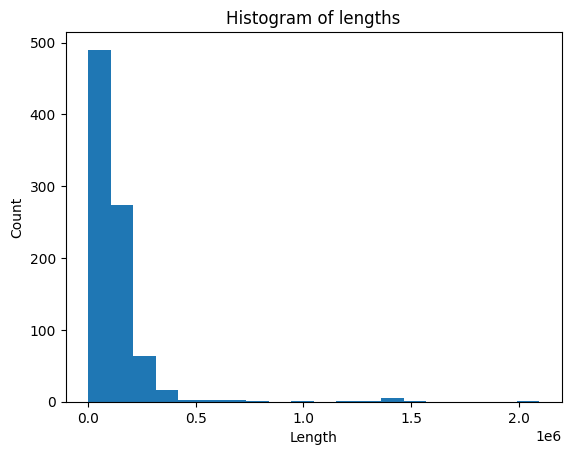

In [3]:
# Load all wave files and measure their length and record the sample rate
wav_files = get_wav_files()
wav_data = [get_wav_data(f) for f in wav_files]
wav_data_by_name = {f: get_wav_data(f) for f in wav_files}
wav_data_by_index = {i: get_wav_data_by_index(i) for i in range(len(wav_files))}

# Count unique sample rates
sample_rates = [d[0] for d in wav_data]
unique_sample_rates = list(set(sample_rates))
print('Unique sample rates:', unique_sample_rates)

# Count unique lengths
lengths = [d[1].shape[0] for d in wav_data]
unique_lengths = list(set(lengths))
print('Unique lengths:', unique_lengths)

#compute length statistics
lengths = np.array(lengths)

print('Length statistics:')
print('Mean:', np.mean(lengths))
print('Median:', np.median(lengths))
print('Min:', np.min(lengths))
print('Max:', np.max(lengths))
print('Std:', np.std(lengths))

# Plot histogram of lengths
plt.hist(lengths, bins=20)
plt.title('Histogram of lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

arbitrary_length = 100000
arbitrary_sample_rate = 48000


# Clean up file names and make into labels
labels = [f.replace('R.wav', '') for f in wav_files]
labels = [f.replace('L.wav', '') for f in labels]
labels = [f.replace('.wav', '') for f in labels]
# Remove 48k from the labels
labels = [l.replace('48K', '') for l in labels]
# Remove all numbers from the labels
labels = [l.replace('0', '') for l in labels]
labels = [l.replace('1', '') for l in labels]
labels = [l.replace('2', '') for l in labels]
labels = [l.replace('3', '') for l in labels]
labels = [l.replace('4', '') for l in labels]
labels = [l.replace('5', '') for l in labels]
labels = [l.replace('6', '') for l in labels]
labels = [l.replace('7', '') for l in labels]
labels = [l.replace('8', '') for l in labels]
labels = [l.replace('9', '') for l in labels]
# Remove all symbols from the labels
labels = [l.replace('_', ' ') for l in labels]
labels = [l.replace('-', ' ') for l in labels] 
labels = [l.replace('(', ' ') for l in labels]
labels = [l.replace(')', ' ') for l in labels]
labels = [l.replace(',', ' ') for l in labels]

# create dict of labels and file names
label_dict = {f: labels[i] for i, f in enumerate(wav_files)}

# Load all wav files and resample them to the same length and sample rate
wav_data_resampled = {f: wav_data_by_name[f] for f in wav_files}

label_list = []
wav_data_list = []
for f in wav_files:
    data = wav_data_resampled[f][1]
    sample_rate = wav_data_resampled[f][0]
    label_list.append(label_dict[f])

    if sample_rate != arbitrary_sample_rate:
        # resample to arbitrary sample rate
        downsample_factor = int(sample_rate/arbitrary_sample_rate)
        data = signal.decimate(data, downsample_factor)
        


    if len(data.shape) > 1:
        data = data[:,0]
    window = signal.windows.exponential(arbitrary_length,center=0, tau=-(arbitrary_length-1)/np.log(0.01),sym=False)
    # rescale data to have range of 0 to 1
    data = np.abs(data/(2.1*np.max(np.abs(data))) + 0.51)
    
    if data.shape[0] <= arbitrary_length:
        #pad the signal with zeros and apply exponential window
        wav_data_resampled[f] = (np.concatenate((data, np.zeros(arbitrary_length - data.shape[0])))*window)
    # elif data.shape[0] > arbitrary_length:
    else:
        # apply exponential window to the truncated signal
        wav_data_resampled[f] = (data[:arbitrary_length]*window)
    wav_data_list.append(wav_data_resampled[f])
        
# TODO: resample to arbitrary sample rate, figure out why we are losing 100 samples


# create dict of labels and resampled wav files
labeled_wav_data_resampled = {label_dict[f]: wav_data_resampled[f] for f in wav_files}

np.save('../data/labeled_wav_data_resampled.npy', labeled_wav_data_resampled)
np.save('../data/label_list.npy', label_list)
np.save('../data/wav_data_list.npy', wav_data_list)

In [4]:
counter = 0
labeled_wav_data_resampled = {}
for f in wav_files:
    counter += 1
    labeled_wav_data_resampled[label_dict[f]] = wav_data_resampled[f]
    

print('Number of files:', counter)
print('Number of labeled files:', len(labeled_wav_data_resampled))
print('Number of labels:', len((label_list)))
print('Number of wav files:', len(wav_data_list))      

Number of files: 862
Number of labeled files: 568
Number of labels: 862
Number of wav files: 862


In [5]:
label_dict

{'Metro Set2.Ls.wav': 'Metro Set.Ls',
 'Washing machine.wav': 'Washing machine',
 '5 Ambiences 14 Bass XXL, 48K R.wav': ' Ambiences  Bass XXL   ',
 'Room B 2.wav': 'Room B ',
 '42-Choiry.wav': ' Choiry',
 '091 - SynthRoom2.wav': '   SynthRoom',
 'MRV_Room2_m-5_Set2.Rs.wav': 'MRV Room m  Set.Rs',
 '3 Rooms 32 Waits Room, 48K R.wav': ' Rooms  Waits Room   ',
 'MRV_Room2_m-q_Set2.Ls.wav': 'MRV Room m q Set.Ls',
 'MRV_Room2_m-st_Set3.wav': 'MRV Room m st Set',
 '6 Spaces 16 Europa, 48K R.wav': ' Spaces  Europa   ',
 'Plate A 1.wav': 'Plate A ',
 '28-Reverb Ramp.wav': ' Reverb Ramp',
 '2 Plates 17 Small Plate, 48K L.wav': ' Plates  Small Plate   ',
 'MRV_Room2_m-q_Set1.Ls.wav': 'MRV Room m q Set.Ls',
 '18-Useful Verb.wav': ' Useful Verb',
 'MRV_RecA_m-5.R.wav': 'MRV RecA m .',
 'RYi 60sBK.Ls.wav': 'RYi sBK.Ls',
 '1 Halls 02 Medium Hall, 48K L.wav': ' Halls  Medium Hall   ',
 'MRV_Room2_m-m_Set4.wav': 'MRV Room m m Set',
 'RYi Power Open Snare.wav': 'RYi Power Open Snare',
 'MRV_RV_Clausto.w

In [6]:
npy_file = '../data/wav_data_list.npy'
dataset = np.load(npy_file, allow_pickle=True)

data = np.array(dataset)
data.shape

(862, 100000)

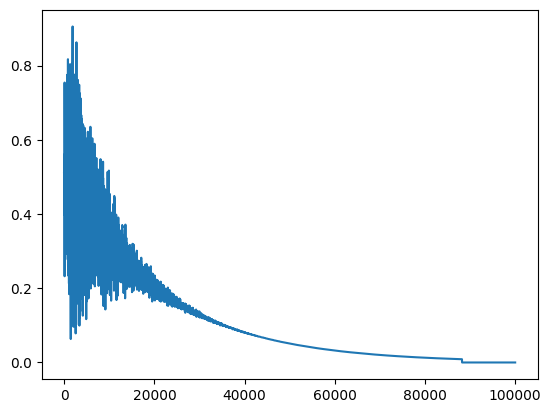

In [7]:
data_plot = data[0,:]

plt.plot(data_plot)
plt.show()



In [8]:
wav_data_resampled_by_index = {i: wav_data_resampled[f] for i, f in enumerate(wav_files)}